# List ranking from incomplete pairwise preferences
** *
*Note: if you are visualizing this notebook directly from GitHub, some mathematical symbols might display incorrectly or not display at all. This same notebook can be rendered from nbviewer by following [this link.](http://nbviewer.jupyter.org/github/david-cortes/datascienceprojects/blob/master/optimization/list_optimization.ipynb)*

This project consists of ranking a list of items (from best to worst) based on pairwise preferences (i.e. data in the form of “Item A is preferred to Item B”) aggregated from many people, which are incomplete (not available for each pair of items) and biased (more likely to be observed for some items than for others). The methods shown here are nevertheless applicable to ranking items from complete or partial orderings from different people, as any ranked list can be decomposed into pairwise preferences between items (i.e. each item is preferred over all items that are below in the ranking).

**Examples of this kind of data:**
* Ordered list of preferences for political candidates from different voters.
* Lists of top-N best artists/games/books/etc. from different users.
* Surveys asking people to compare a series of two items at a time (pick the better one).
* Clicks on a vertical ranked list of items shown in random orders to users, if we assume that a clicked item is preferred to items that were ranked above and seen by the user but not clicked  - overall idea is explained in [Joachims, T., Granka, L., Pan, B., Hembrooke, H., Radlinski, F., & Gay, G. (2007). Evaluating the accuracy of implicit feedback from clicks and query reformulations in web search. ACM Transactions on Information Systems (TOIS), 25(2), 7.](https://www.researchgate.net/profile/Bing_Pan/publication/220515686_Evaluating_the_accuracy_of_implicit_feedback_from_clicks_and_query_reformulations_in_Web_search/links/0deec52051abbe27d6000000.pdf)

The original idea was to rank an electronic catalog of items based on pairwise preferences deduced from clicks and is explained in [my thesis](https://www.hse.ru/edu/vkr/182626307). Since the data originally used is not public, I’ll simulate data (random numbers following statistical distributions) that resembles the original one.

The rankings here are evaluated in terms of the pairwise preferences that they satisfy minus the pairwise preferences that they violate – from here on defined as their _score_. Thus, if we observe the following preferences: $ A\succ B, A\succ B, A\succ B, A\prec B $, then an ordering that puts A above B would get +2, whereas an ordering that puts B above A would get -2.

The goal is to reconstruct what the overall ranking of items is based on the observed preferences, and thus it is reasonable to assume that orderings with a higher such score are more representative of the overall real ranking than those with a lower score.
** *
## Sections

[1. What the data looks like](#p1)

[2. Simulating the data](#p2)

[3. Algorithms](#p3)
* [3.1 Implementing the algorithms](#p31)
* [3.2 Evaluating and timing the algorithms](#p32)

[4. Comparing these orderings to the simulation's underlying order](#p4)
* [4.1 Defining the metrics](#p41)
* [4.2 Evaluating the orderings](#p42)

[5. Ranking a larger list](#p5)
** *

<a id="p1"></a>
## 1. What the data looks like

This example will simulate data in the following way:
* There is a list of items, which have an overall attractiveness for users - this will be simulated as a random number for each item, with a bigger number meaning that the item is better, thus each item is comparable to each other.
* There are many users, each of which has different preferences for each item, but these tend to be similar across users – this will be simulated as a random number, from a distribution with less spread than the one for items, multiplied by the number reflecting the overall goodness of each item.
* Some items are easier to sample than others – that is, it’s easier or more common to get to know the preference for a user for some items than for others- and their probability is proportional to some randomly-generated numbers (~Beta(1,1)).
* The data available comes in the form of stated preferences between two products from different users – this will be simulated as picking two items and comparing their ‘goodness’ or ‘attractiveness’ as defined above, then adding which one was preferred to the data pool to work with.
* Overall, there is information only for some pairs of items, but not for all.
* Items and users are referred to by their numerical ID - this doesn't mean anything and is used only for identification purposes.

** *
## A look at some small simulated data


In [1]:
import numpy as np, pandas as pd
from random import shuffle

nusers=4
nitems=6

np.random.seed(10)
items=[i for i in range(nitems)]
item_probs=np.random.beta(a=1,b=1,size=nitems)
item_probs=item_probs/np.sum(item_probs)
item_goodness=np.random.beta(a=2,b=2,size=nitems)
user_preferences=[np.random.beta(a=3,b=3,size=nitems)*item_goodness for u in range(nusers)]
agg_item_goodness=np.zeros((nitems))
for u in range(nusers):
    agg_item_goodness+=user_preferences[u]

preferences=list()
for iteration in range(100):
    chosen_user=np.random.randint(low=0,high=nusers)
    for sample in range(3):
        chosen_items=np.random.choice(items,size=2,replace=False,p=item_probs)
        if chosen_items[0]==chosen_items[1]:
            continue
        goodness_A=user_preferences[chosen_user][chosen_items[0]]
        goodness_B=user_preferences[chosen_user][chosen_items[1]]
        if goodness_A>goodness_B:
            preferences.append((chosen_user,chosen_items[0],chosen_items[1]))
        else:
            preferences.append((chosen_user,chosen_items[1],chosen_items[0]))
            
shuffle(preferences)
pd.DataFrame(preferences, columns=['User','Prefers This Item','Over This Item']).head()

,User,Prefers This Item,Over This Item
0,2,0,5
1,1,5,3
2,2,0,2
3,2,0,3
4,3,0,1


These lists of preferences are aggregated by summing the number of times that preference “Item A is preferred to Item B” is observed and subtracting from it the number of times that preference “Item B is preferred to Item A” is observed.

The aggregated preferences are stored in a table reflecting the lower-triangular matrix of a full item x item matrix, thus the entry for “ItemA>ItemB” is in the cell [A,B] if the ID of item A is less than the ID of item B, and is -1 x cell [B,A] otherwise.

In [2]:
from collections import defaultdict

aggregated_preferences=defaultdict(lambda: 0)
for pref in preferences:
    if pref[1]<pref[2]:
        aggregated_preferences[(pref[1],pref[2])]+=1
    else:
        aggregated_preferences[(pref[2],pref[1])]-=1

# some preferences are hidden, thus some will be deleted at random here
for iteration in range(3):
    chosen_items=np.random.randint(low=0,high=nitems,size=2)
    if chosen_items[0]==chosen_items[1]:
        continue
    if chosen_items[0]<chosen_items[1]:
        del aggregated_preferences[(chosen_items[0],chosen_items[1])]
    else:
        aggregated_preferences[(chosen_items[1],chosen_items[0])]
aggregated_preferences

defaultdict(<function __main__.<lambda>>,
            {(0, 1): 54,
             (0, 2): 13,
             (0, 3): 27,
             (0, 5): 57,
             (1, 2): 1,
             (1, 3): -27,
             (1, 5): -35,
             (2, 3): 0,
             (2, 5): -12})

Ranking with these example preferences:

Best order: (0, 5, 2, 3, 1, 4)
Best score: 96
Theoretical maximum (perhaps not feasible): 226

Item goodness defined in simulation: [(0, 0.88), (5, 0.64), (4, 0.62), (3, 0.56), (2, 0.3), (1, 0.22)]
Item goodness across all users in simulation: [(0, 2.1), (4, 1.51), (5, 1.05), (3, 0.96), (2, 0.62), (1, 0.52)]


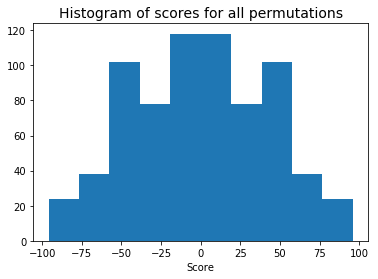

In [3]:
from itertools import permutations
from copy import deepcopy
from matplotlib import pyplot as plt
%matplotlib inline

def eval_ranking(order,aggregated_preferences):
    score=0
    for ind in range(len(order)-1):
        el1=order[ind]
        el2=order[ind+1]
        if el1<el2:
            score+=aggregated_preferences[(el1,el2)]
        else:
            score-=aggregated_preferences[(el2,el1)]
    return score

best_score=-100
worst_score=100
scores=list()
for order in permutations([i for i in range(nitems)]):
    score=eval_ranking(order,aggregated_preferences)
    scores.append(score)
    if score>best_score:
        best_score=deepcopy(score)
        best_order=order
        
print('Best order:',best_order)
print("Best score:",best_score)
print('Theoretical maximum (perhaps not feasible):',np.sum([np.abs(v) for v in aggregated_preferences.values()]))
print()
print('Item goodness defined in simulation:',[(el,eval("{0:.2f}".format(item_goodness[el]))) for el in np.argsort(-item_goodness)])
print('Item goodness across all users in simulation:',[(el,eval("{0:.2f}".format(agg_item_goodness[el]))) for el in np.argsort(-agg_item_goodness)])
_=plt.hist(np.array(scores))
_=plt.title('Histogram of scores for all permutations',size=14)
_=plt.xlabel('Score')

<a id="p2"></a>
## 2. Simulating the data

Let's now simulate a more realistic scenario:

* List of 30 items.
* Sample with replacement of random 300 users from a population of 500, with 4 preferences stated from each.
* Higher sampling bias (P~Beta(2,2)).
* Slightly less spread item goodness (~Beta(3,3)) and less spread user variation in preference (~Beta(4,4)).

In [4]:
nusers=500
nitems=30
aggregated_preferences=defaultdict(lambda: 0)

def add_preferences(el1,el2):
    global aggregated_preferences
    
    if el1<el2:
        aggregated_preferences[(el1,el2)]+=1
    else:
        aggregated_preferences[(el2,el1)]-=1

np.random.seed(100)
items=[i for i in range(nitems)]
item_probs=np.random.beta(a=2,b=2,size=nitems)
item_probs=item_probs/np.sum(item_probs)
item_goodness=np.random.beta(a=3,b=3,size=nitems)
user_preferences=[np.random.beta(a=4,b=4,size=nitems)*item_goodness for u in range(nusers)]
agg_item_goodness=np.zeros((nitems))
for u in range(nusers):
    agg_item_goodness+=user_preferences[u]

for iteration in range(300):
    chosen_user=np.random.randint(low=0,high=nusers)
    for sample in range(4):
        chosen_items=np.random.choice(items,size=2,replace=False,p=item_probs)
        if chosen_items[0]==chosen_items[1]:
            continue
        goodness_A=user_preferences[chosen_user][chosen_items[0]]
        goodness_B=user_preferences[chosen_user][chosen_items[1]]
        if goodness_A>goodness_B:
            add_preferences(chosen_items[0],chosen_items[1])
        else:
            add_preferences(chosen_items[1],chosen_items[0])
            
print('Theoretical maximum score:',np.sum([np.abs(v) for v in aggregated_preferences.values()]))
print('Number of pairwise preferences observed:',len([v for v in aggregated_preferences.values() if v!=0]))
print('Number of pairs in the list:',int(nitems*(nitems-1)/2))

Theoretical maximum score: 812
Number of pairwise preferences observed: 324
Number of pairs in the list: 435


<a id="p3"></a>
## 3. Algorithms

The example above with only 6 items found the best ordering by evaluating all the possible permutations of those 6 items, but such a brute-force search of all the orderings becomes infeasible when there are more than a dozen items (there are items! (factorial) possible orderings, so for example for 50 items there are 50!=3x10^64 different orderings).

As such, this larger 30-element list will be ranked with discrete optimization algorithms based on local search, by swapping two items at a time within a list, starting with a random order. In addition, I also implemented two algorithms from some papers: [KwikSort]( http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.296.8422&rep=rep1&type=pdf) and [Greedy-Order]( http://arxiv.org/pdf/1105.5464) – the second one being perhaps the most straightforward heuristic; and two other common techniques: PageRank (the original algorithm used by Google for helping to rank web pages) and a convex relaxation of the problem with l1 penalty using a black-box SDP solver, by taking the difference between scores between two items plus a margin.

While evaluating the score of an ordering requires checking the table of aggregated preferences for every pair in the list (of which there are items x (items-1)/2), it’s also possible to look for only the net effect that one particular pair of items has when they occupy their current position in the list, which implies checking only the preferences that involve this pair of items when they are at their current positions (which only implies (items -1) + (items -2) relationships).

** *
#### Min-conflict (complexity O(items^3)):

    While it’s possible to improve the score
        For each pair of items in the list:
            Check the effect on score of having it as it is vs. reversed
        Swap the pair that brought the highest score improvement
        Repeat

** *
#### Random swaps (complexity O(items x iterations x repetitions + repetitions x items^2)):

    Repeat r times:
        Repeat n times:
            Pick a random pair of items
                Check the effect on score of having it as it is vs. reversed        
                Swap them if it improves the score
        Calculate the score of the obtained ordering
        If it's the highest score seen so far, save this ordering
    Output the ordering with the highest score seen

** *
#### Metropolis-Hastings swaping (complexity O(items x iterations)):

    Repeat n times:
        Pick a random pair of items   
            Check the effect on score of having it as it is vs. reversed       
            If swapping them improves the score:        
                Swap them          
                Update the score estimate           
                If it's the highest score ever seen, save this ordering            
            Else:        
                Swap them with a small probability inversely proportional to the score decrease            
                Update score estimate if they were swaped           
    Output the ordering with the highest score seen

In addition, I also implemented two algorithms from some papers: [Kwik-Sort]( http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.296.8422&rep=rep1&type=pdf) and [Greedy-Order]( http://arxiv.org/pdf/1105.5464)
** *
<a id="p31"></a>
### 3.1 Implementing the algorithms

In [5]:
#Helpful functions
import random, cvxpy as cvx

#Calculating score for a given order
def list_score(ordering,prefs):
    score=0
    cnt=len(ordering)
    for i in range(cnt-1):
        for j in range(i+1,cnt):
            e1,e2=ordering[i],ordering[j]
            if e1<e2:
                score+=prefs[(e1,e2)]
            else:
                score-=prefs[(e2,e1)]
    return score

#Generate all the possible pairs, will be used at each step
def get_pairs_indices(n):
    for i in range(n-1):
        for j in range(i+1,n):
            yield i,j

#Give a preference and see how many constrains will it satisy minus how many will it violate           
def score_pref(e1_name,e2_name,prefs_dict):
    if e1_name<e2_name:
        return prefs_dict[e1_name,e2_name]
    else:
        return -prefs_dict[e2_name,e1_name]

#examine the net effect of having a pair as it is vs. the other way around
def pair_net_effect(lst,pair_ind,prefs_dict):
    lst2=deepcopy(lst)
    e1_ind,e2_ind=pair_ind
    if e1_ind>e2_ind:
        e1_ind,e2_ind=e2_ind,e1_ind
    lst2[e1_ind],lst2[e2_ind]=lst2[e2_ind],lst2[e1_ind]
    score=0
    rev_score=0
    for p1 in range(e1_ind):
        score+=score_pref(lst[p1],lst[e1_ind],prefs_dict)
        rev_score+=score_pref(lst2[p1],lst2[e1_ind],prefs_dict)        
        score+=score_pref(lst[p1],lst[e2_ind],prefs_dict)
        rev_score+=score_pref(lst2[p1],lst2[e2_ind],prefs_dict)
    for p2 in range(e1_ind+1,e2_ind):
        score+=score_pref(lst[e1_ind],lst[p2],prefs_dict)
        rev_score+=score_pref(lst2[e1_ind],lst2[p2],prefs_dict)
        score+=score_pref(lst[p2],lst[e2_ind],prefs_dict)
        rev_score+=score_pref(lst2[p2],lst2[e2_ind],prefs_dict)
    for p3 in range(e2_ind+1,len(lst)):
        score+=score_pref(lst[e1_ind],lst[p3],prefs_dict)
        rev_score+=score_pref(lst2[e1_ind],lst2[p3],prefs_dict)
        score+=score_pref(lst[e2_ind],lst[p3],prefs_dict)
        rev_score+=score_pref(lst2[e2_ind],lst2[p3],prefs_dict)        
    score+=score_pref(lst[e1_ind],lst[e2_ind],prefs_dict)
    rev_score+=score_pref(lst2[e1_ind],lst2[e2_ind],prefs_dict)
    return (score,rev_score)

#Swap a pair of items in a list
def swap(lst,pair_tuple):
    lst[pair_tuple[0]],lst[pair_tuple[1]]=lst[pair_tuple[1]],lst[pair_tuple[0]]

######################

#Implementing the algorithms

def greedy_ranking(list_els,dict_prefs):
    ordering=list()
    els=deepcopy(list_els)
    while els!=[]:
        best_score=float("-infinity")
        for e1 in els:
            score_el=0
            for e2 in els:
                if e1==e2:
                    continue
                score_el+=score_pref(e1,e2,dict_prefs)
            if score_el>best_score:
                best_score=score_el
                best_el=e1
        ordering.append(best_el)
        els.remove(best_el)
    return ordering

def kwiksort(list_els,dict_prefs):
    if list_els==[]:
        return []
    pivot=np.random.choice(list_els)
    left=[]
    right=[]
    for el in list_els:
        if el==pivot:
            continue
        else:
            if score_pref(el,pivot,dict_prefs)<0:
                right.append(el)
            else:
                left.append(el)
    left=kwiksort(left,dict_prefs)
    right=kwiksort(right,dict_prefs)
    return left+[pivot]+right

def kwiksort_multiple_runs(list_els,dict_prefs,runs=10):
    best_score=float("-infinity")
    for run in range(runs):
        ordering=kwiksort(list_els,dict_prefs)
        score=list_score(ordering,dict_prefs)
        if score>best_score:
            best_score=score
            best_order=ordering
    return best_order

def pagerank(list_els,dict_prefs,eps_search=20):
    prefs_mat=np.zeros((nitems,nitems))
    for k,v in aggregated_preferences.items():
        if v==0:
            continue
        elif v>0:
            prefs_mat[k[1],k[0]]+=v
        else:
            prefs_mat[k[0],k[1]]-=v
    prefs_mat_orig=prefs_mat.copy()
    eps_grid=list(.5**np.logspace(0,1,eps_search))
    best=-10^5
    best_order=None
    
    for eps in eps_grid:
        prefs_mat=prefs_mat_orig.copy()
        for i in range(nitems):
            prefs_mat[:,i]+=eps
            tot=np.sum(prefs_mat[:,i])
            prefs_mat[:,i]=prefs_mat[:,i]/tot

        
        pr=np.ones((nitems,1))/nitems
        for i in range(30):
            pr=prefs_mat.dot(pr)
        lst_pagerank=list(np.argsort(pr.reshape(-1)))
        score_this_order=list_score(lst_pagerank,aggregated_preferences)
        if score_this_order>best:
            best=score_this_order
            best_order=deepcopy(lst_pagerank)
    return best_order

def cvx_relaxation(list_els,dict_prefs):
    r=cvx.Variable(nitems)    
    obj=0
    for k,v in aggregated_preferences.items():
        if v>0:
            obj+=cvx.pos(v*r[k[0]]-v*r[k[1]]+1)
        else:
            obj+=cvx.pos(-v*r[k[1]]+v*r[k[0]]+1)
    prob=cvx.Problem(cvx.Minimize(obj))
    prob.solve()
    return list(np.argsort(np.array(r.value).reshape(-1)))

def minconflict(initial_guess,dict_prefs):
    ordering=deepcopy(initial_guess)
    while True:
        best=0
        best_swap=None
        pairs_indices=get_pairs_indices(len(ordering))
        for pair_ind in pairs_indices:
            score_as_is,score_rev=pair_net_effect(ordering,pair_ind,dict_prefs)
            improvement=(score_rev-score_as_is)
            if improvement>best:
                best=improvement
                best_swap=pair_ind
        if best_swap==None:
            break
        else:
            swap(ordering,best_swap)
    return ordering

def random_swaps(initial_guess,dict_prefs,iterations=10000,repetitions=3):
    best=0
    for rep in range(repetitions):
        ordering=deepcopy(initial_guess)
        for it in range(iterations):
            candidates_ind=random.sample(range(len(ordering)), 2)
            score_as_is,score_rev=pair_net_effect(ordering,candidates_ind,dict_prefs)
            if score_rev>score_as_is:
                swap(ordering,candidates_ind)
        score=list_score(ordering,dict_prefs)
        if score>best:
            best=score
            best_ordering=deepcopy(ordering)
    return best_ordering

def metropolis_hastings(initial_guess,dict_prefs,iterations=10000,explore_fact=1):
    ordering=deepcopy(initial_guess)
    best=0
    current_score=0
    for it in range(iterations):
        candidates_ind=random.sample(range(len(ordering)), 2)
        score_as_is,score_rev=pair_net_effect(ordering,candidates_ind,dict_prefs)
        if score_rev>score_as_is:
            swap(ordering,candidates_ind)
            current_score+=(score_rev-score_as_is)
            if current_score>best:
                best=current_score
                best_ordering=deepcopy(ordering)
        else:
            criterion=(2*explore_fact)**(score_rev-score_as_is)
            if np.random.random()<=criterion:
                swap(ordering,candidates_ind)
                current_score+=(score_rev-score_as_is)
    return best_ordering

<a id="p32"></a>
### 3.2 Evaluating and timing the algorithms

In [6]:
import time

#Generating a random ordering
np.random.seed(1)
random_ordering=deepcopy(items)
np.random.shuffle(random_ordering)

start_time = time.time()
greedy_rank=greedy_ranking(random_ordering,aggregated_preferences)
time_greedy_rank=time.time() - start_time

np.random.seed(1)
random.seed(1)
start_time = time.time()
ks_rank=kwiksort_multiple_runs(random_ordering,aggregated_preferences,runs=10000)
time_kwiksort=time.time() - start_time

np.random.seed(1)
random.seed(1)
start_time = time.time()
pr_rank=pagerank(random_ordering,aggregated_preferences)
time_pagerank=time.time() - start_time

np.random.seed(1)
random.seed(1)
start_time = time.time()
cvxrelax_rank=cvx_relaxation(random_ordering,aggregated_preferences)
time_cvxrelax=time.time() - start_time

start_time = time.time()
mc_rank=minconflict(random_ordering,aggregated_preferences)
time_minconflict=time.time() - start_time

np.random.seed(1)
random.seed(1)
start_time = time.time()
rs_rank=random_swaps(random_ordering,aggregated_preferences,iterations=50000)
time_random_swaps=time.time() - start_time

np.random.seed(1)
random.seed(1)
start_time = time.time()
mh_rank=metropolis_hastings(random_ordering,aggregated_preferences,iterations=50000,explore_fact=8)
time_metropolis=time.time() - start_time

lst_scores={'Greedy Ranking':list_score(greedy_rank,aggregated_preferences),
            'Kwik-Sort (10,000 trials)':list_score(ks_rank,aggregated_preferences),
            'PageRank (tuned epsilon)':list_score(pr_rank,aggregated_preferences),
            'Convex relaxation':list_score(cvxrelax_rank,aggregated_preferences),
            'Min-Conflict':list_score(mc_rank,aggregated_preferences),
            'Random Swaps':list_score(rs_rank,aggregated_preferences),
            'Metropolis-Hastings Swapping':list_score(mh_rank,aggregated_preferences)
           }
lst_times={'Greedy Ranking':time_greedy_rank,
            'Kwik-Sort (10,000 trials)':time_kwiksort,
            'PageRank (tuned epsilon)':time_pagerank,
            'Convex relaxation':time_cvxrelax,
            'Min-Conflict':time_minconflict,
            'Random Swaps':time_random_swaps,
            'Metropolis-Hastings Swapping':time_metropolis
           }

eval_df=pd.DataFrame.from_dict(lst_scores,orient='index').rename(columns={0:'Score'}).sort_values('Score',ascending=False)
runtimes=pd.DataFrame.from_dict(lst_times,orient='index').rename(columns={0:'Time (seconds)'})
eval_df.join(runtimes)

,Score,Time (seconds)
Metropolis-Hastings Swapping,748,7.144304
Min-Conflict,734,1.773097
Random Swaps,728,20.773540
"Kwik-Sort (10,000 trials)",722,7.611491
Convex relaxation,714,1.228070
PageRank (tuned epsilon),660,0.081005
Greedy Ranking,650,0.006000


<a id="p4"></a>
## 4. Comparing these orderings to the simulation's underlying order


Since these incomplete pairwise preferences were generated from a complete ranked list, it’s possible to evaluate them also in terms of how similar the order that they output is to the real ranking (in this case, we know it because we generated these samples from it plus a small disturbance to account for user preferences, but in a real situation, this ranking wouldn’t be available).


**Some good criteria for comparing one ranked list to another are:**

* The fraction of pairs ranked in same order relative to each other (e.g. if A is ranked above B in both lists, that pair adds to their similarity, whereas if A is ranked above B in one while B is ranked above A in another, it doesn’t add to their similarity).
* Symmetric AP correlation, described in [A new rank correlation coefficient for information retrieval](http://net.pku.edu.cn/~webg/src/paradise/reference/click-through%20evaluation/2008-SIGIR-A%20new%20rank%20correlation%20coefficient%20for%20information%20retrieval.pdf).

** *
<a id="p41"></a>
### 4.1 Defining the metrics

In [7]:
#implementing useful metrics
def fraction_conc_pairs(list1,list2):
    pairs_list1=set()
    for i in range(len(list1)-1):
        for j in range (i+1,len(list1)):
            pairs_list1.add((list1[i],list1[j]))
            
    p=0
    q=0
    for i in range(len(list2)-1):
        for j in range (i+1,len(list2)):
            if (list2[i],list2[j]) in pairs_list1:
                p+=1
            else:
                q+=1
    return p/(p+q)

def ap_cor(list1,list2):
    pairs_list2=set()
    p_prime=0
    for i in range(len(list2)-1):
        for j in range (i+1,len(list2)):
            pairs_list2.add((list2[i],list2[j]))
    
    for i in range(1,len(list1)):
        for j in range(i):
            if (list1[j],list1[i]) in pairs_list2:
                c=1
            else:
                c=0
            p_prime+=c/i
    p_prime=p_prime/(len(list1)-1)
    return p_prime-(1-p_prime)

def sym_ap_cor(list1,list2):
    return (ap_cor(list1,list2)+ap_cor(list2,list1))/2

<a id="p42"></a>
### 4.2 Evaluating the orderings

In [8]:
best_theoretical_order=list(np.argsort(-item_goodness))

lst_conc_pairs={'Greedy Ranking':'{:.2%}'.format(fraction_conc_pairs(greedy_rank,best_theoretical_order)),
            'Kwik-Sort (10,000 trials)':'{:.2%}'.format(fraction_conc_pairs(ks_rank,best_theoretical_order)),
            'PageRank (tuned epsilon)':'{:.2%}'.format(fraction_conc_pairs(pr_rank,best_theoretical_order)),
            'Convex relaxation':'{:.2%}'.format(fraction_conc_pairs(cvxrelax_rank,best_theoretical_order)),
            'Min-Conflict':'{:.2%}'.format(fraction_conc_pairs(mc_rank,best_theoretical_order)),
            'Random Swaps':'{:.2%}'.format(fraction_conc_pairs(rs_rank,best_theoretical_order)),
            'Metropolis-Hastings Swapping':'{:.2%}'.format(fraction_conc_pairs(mh_rank,best_theoretical_order))
           }
lst_sym_ap_cor={'Greedy Ranking':'{:.2%}'.format(sym_ap_cor(greedy_rank,best_theoretical_order)),
            'Kwik-Sort (10,000 trials)':'{:.2%}'.format(sym_ap_cor(ks_rank,best_theoretical_order)),
            'PageRank (tuned epsilon)':'{:.2%}'.format(sym_ap_cor(pr_rank,best_theoretical_order)),
            'Convex relaxation':'{:.2%}'.format(sym_ap_cor(cvxrelax_rank,best_theoretical_order)),
            'Min-Conflict':'{:.2%}'.format(sym_ap_cor(mc_rank,best_theoretical_order)),
            'Random Swaps':'{:.2%}'.format(sym_ap_cor(rs_rank,best_theoretical_order)),
            'Metropolis-Hastings Swapping':'{:.2%}'.format(sym_ap_cor(mh_rank,best_theoretical_order))
           }

eval_df=pd.DataFrame.from_dict(lst_scores,orient='index').rename(columns={0:'Score'}).sort_values('Score',ascending=False)
runtimes=pd.DataFrame.from_dict(lst_times,orient='index').rename(columns={0:'Time (seconds)'})
fcp=pd.DataFrame.from_dict(lst_conc_pairs,orient='index').rename(columns={0:'% concordant pairs w/generator'})
sapc=pd.DataFrame.from_dict(lst_sym_ap_cor,orient='index').rename(columns={0:'Symmetrical AP correlation w/generator'})
eval_df.join(runtimes).join(fcp).join(sapc)

,Score,Time (seconds),% concordant pairs w/generator,Symmetrical AP correlation w/generator
Metropolis-Hastings Swapping,748,7.144304,86.67%,62.38%
Min-Conflict,734,1.773097,86.67%,66.71%
Random Swaps,728,20.773540,81.84%,54.92%
"Kwik-Sort (10,000 trials)",722,7.611491,86.90%,68.55%
Convex relaxation,714,1.228070,86.44%,64.14%
PageRank (tuned epsilon),660,0.081005,83.45%,49.50%
Greedy Ranking,650,0.006000,79.31%,52.37%


Despite achieving lower scores, here Kwik-Sort managed to produce an ordering that is more similar to the underlying order form which the pairwise preferences were simulated. Metropolis-Hastings and Min-Conflict were very close though, and the relative outcomes of algorithms would vary with a different simulation.

Taking a look at which elements do each put at the top and at the bottom – the numbers in each column reflect the item IDs and are ordered according to their rank under each ordering:

In [9]:
pd.DataFrame({"Simulation's order":best_theoretical_order,'Metropolis-Hastings Swapping':mh_rank,
              'PageRank':pr_rank, 'Convex relaxation':cvxrelax_rank, 'Min-Conflict':mc_rank,
              'Random Swaps':rs_rank,'Kwik-Sort (10,000 trials)':ks_rank,'Greedy Ranking':greedy_rank}).head(6)

,Convex relaxation,Greedy Ranking,"Kwik-Sort (10,000 trials)",Metropolis-Hastings Swapping,Min-Conflict,PageRank,Random Swaps,Simulation's order
0,16,12,16,25,16,12,16,16
1,13,10,25,13,18,18,15,18
2,12,16,18,16,12,19,25,12
3,18,25,12,18,19,10,18,4
4,25,18,10,12,10,0,12,25
5,0,24,13,10,13,25,19,14


In [10]:
pd.DataFrame({"Simulation's order":best_theoretical_order,'Metropolis-Hastings Swapping':mh_rank,
              'PageRank':pr_rank, 'Convex relaxation':cvxrelax_rank, 'Min-Conflict':mc_rank,
              'Random Swaps':rs_rank,'Kwik-Sort (10,000 trials)':ks_rank,'Greedy Ranking':greedy_rank}).tail(6)

,Convex relaxation,Greedy Ranking,"Kwik-Sort (10,000 trials)",Metropolis-Hastings Swapping,Min-Conflict,PageRank,Random Swaps,Simulation's order
24,22,23,11,29,22,23,22,11
25,29,28,7,22,27,8,23,27
26,23,8,29,23,8,21,20,8
27,28,19,23,28,23,20,28,23
28,8,3,28,8,28,3,8,28
29,3,0,3,3,3,28,3,3


<a id="p5"></a>
## 5. Ranking a larger list

The previous list only had 30 elements, and while this makes it infeasible to order by brute-force search, the problem is still smallish. Not all algorithms scale well with a bigger sample size.

Now doing the same but with a bigger simulation:
* 250 items.
* 3,000 sampled users (from an infinite population) with 5 preferences each.
* Same distribution for sampling bias, item goodness and variation in user preference.

This time there will only be information about pairwise preferences for 1/3 of the pairs of items. Since Min-Conflict scales poorly with the number of items, it won't be tried this time.

In [11]:
nitems=250
aggregated_preferences=defaultdict(lambda: 0)

np.random.seed(123)
items=[i for i in range(nitems)]
item_probs=np.random.beta(a=2,b=2,size=nitems)
item_probs=item_probs/np.sum(item_probs)
item_goodness=np.random.beta(a=3,b=3,size=nitems)
user_preferences=[np.random.beta(a=4,b=4,size=nitems)*item_goodness for u in range(nusers)]
agg_item_goodness=np.zeros((nitems))
for u in range(nusers):
    agg_item_goodness+=user_preferences[u]

for iteration in range(3000):
    prefs_user=np.random.beta(a=4,b=4,size=nitems)*item_goodness
    for sample in range(5):
        chosen_items=np.random.choice(items,size=2,replace=False,p=item_probs)
        if chosen_items[0]==chosen_items[1]:
            continue
        goodness_A=prefs_user[chosen_items[0]]
        goodness_B=prefs_user[chosen_items[1]]
        if goodness_A>goodness_B:
            add_preferences(chosen_items[0],chosen_items[1])
        else:
            add_preferences(chosen_items[1],chosen_items[0])
            
print('Theoretical maximum score:',np.sum([np.abs(v) for v in aggregated_preferences.values()]))
print('Number of pairwise preferences observed:',len([v for v in aggregated_preferences.values() if v!=0]))
print('Number of pairs in the list:',int(nitems*(nitems-1)/2))

Theoretical maximum score: 12716
Number of pairwise preferences observed: 10067
Number of pairs in the list: 31125


In [12]:
#Generating a random ordering
np.random.seed(1)
random_ordering=deepcopy(items)
np.random.shuffle(random_ordering)

start_time = time.time()
greedy_rank=greedy_ranking(random_ordering,aggregated_preferences)
time_greedy_rank=time.time() - start_time

np.random.seed(1)
random.seed(1)
start_time = time.time()
ks_rank=kwiksort_multiple_runs(random_ordering,aggregated_preferences,runs=1000)
time_kwiksort=time.time() - start_time

np.random.seed(1)
random.seed(1)
start_time = time.time()
pr_rank=pagerank(random_ordering,aggregated_preferences)
time_pagerank=time.time() - start_time

np.random.seed(1)
random.seed(1)
start_time = time.time()
cvxrelax_rank=cvx_relaxation(random_ordering,aggregated_preferences)
time_cvxrelax=time.time() - start_time

np.random.seed(1)
random.seed(1)
start_time = time.time()
rs_rank=random_swaps(random_ordering,aggregated_preferences,iterations=50000)
time_random_swaps=time.time() - start_time

np.random.seed(1)
random.seed(1)
start_time = time.time()
mh_rank=metropolis_hastings(random_ordering,aggregated_preferences,iterations=100000,explore_fact=8)
time_metropolis=time.time() - start_time

best_theoretical_order=list(np.argsort(-item_goodness))

lst_scores={'Greedy Ranking':list_score(greedy_rank,aggregated_preferences),
            'Kwik-Sort (1,000 trials)':list_score(ks_rank,aggregated_preferences),
            'PageRank (tuned epsilon)':list_score(pr_rank,aggregated_preferences),
            'Convex relaxation':list_score(cvxrelax_rank,aggregated_preferences),
            'Random Swaps':list_score(rs_rank,aggregated_preferences),
            'Metropolis-Hastings Swapping':list_score(mh_rank,aggregated_preferences)
           }
lst_times={'Greedy Ranking':time_greedy_rank,
            'Kwik-Sort (1,000 trials)':time_kwiksort,
            'PageRank (tuned epsilon)':time_pagerank,
            'Convex relaxation':time_cvxrelax,
            'Random Swaps':time_random_swaps,
            'Metropolis-Hastings Swapping':time_metropolis
           }

lst_conc_pairs={'Greedy Ranking':'{:.2%}'.format(fraction_conc_pairs(greedy_rank,best_theoretical_order)),
            'Kwik-Sort (1,000 trials)':'{:.2%}'.format(fraction_conc_pairs(ks_rank,best_theoretical_order)),
            'PageRank (tuned epsilon)':'{:.2%}'.format(fraction_conc_pairs(pr_rank,best_theoretical_order)),
            'Convex relaxation':'{:.2%}'.format(fraction_conc_pairs(cvxrelax_rank,best_theoretical_order)),
            'Random Swaps':'{:.2%}'.format(fraction_conc_pairs(rs_rank,best_theoretical_order)),
            'Metropolis-Hastings Swapping':'{:.2%}'.format(fraction_conc_pairs(mh_rank,best_theoretical_order))
           }
lst_sym_ap_cor={'Greedy Ranking':'{:.2%}'.format(sym_ap_cor(greedy_rank,best_theoretical_order)),
            'Kwik-Sort (1,000 trials)':'{:.2%}'.format(sym_ap_cor(ks_rank,best_theoretical_order)),
            'PageRank (tuned epsilon)':'{:.2%}'.format(sym_ap_cor(pr_rank,best_theoretical_order)),
            'Convex relaxation':'{:.2%}'.format(sym_ap_cor(cvxrelax_rank,best_theoretical_order)),
            'Random Swaps':'{:.2%}'.format(sym_ap_cor(rs_rank,best_theoretical_order)),
            'Metropolis-Hastings Swapping':'{:.2%}'.format(sym_ap_cor(mh_rank,best_theoretical_order))
           }

eval_df=pd.DataFrame.from_dict(lst_scores,orient='index').rename(columns={0:'Score'}).sort_values('Score',ascending=False)
runtimes=pd.DataFrame.from_dict(lst_times,orient='index').rename(columns={0:'Time (seconds)'})
fcp=pd.DataFrame.from_dict(lst_conc_pairs,orient='index').rename(columns={0:'% concordant pairs w/generator'})
sapc=pd.DataFrame.from_dict(lst_sym_ap_cor,orient='index').rename(columns={0:'Symmetrical AP correlation w/generator'})
eval_df.join(runtimes).join(fcp).join(sapc)

,Score,Time (seconds),% concordant pairs w/generator,Symmetrical AP correlation w/generator
Metropolis-Hastings Swapping,9102,97.669168,89.52%,65.42%
Random Swaps,9006,146.839168,88.46%,62.47%
Convex relaxation,8396,159.802713,92.52%,73.78%
PageRank (tuned epsilon),7568,2.920900,82.59%,49.81%
Greedy Ranking,7292,2.895627,77.77%,45.54%
"Kwik-Sort (1,000 trials)",6120,28.923745,70.54%,28.62%


This time, Kwik-Sort didn't fare so well with this larger and more sparse input data, and the convex relaxation of the problem with l1 penalty seemed to reconstruct an order closest to the original. Metropolis-Hastings again did well both in terms of score and correlation with the real order behind the simulation.

Again taking a look at which elements do each put at the top and at the bottom – the numbers in each column reflect the item IDs and are ordered according to their rank under each ordering:

In [13]:
pd.DataFrame({"Simulation's order":best_theoretical_order,'Metropolis-Hastings Swapping':mh_rank,
              'PageRank':pr_rank, 'Convex relaxation':cvxrelax_rank,
              'Random Swaps':rs_rank,'Kwik-Sort (10,000 trials)':ks_rank,'Greedy Ranking':greedy_rank}).head(15)

,Convex relaxation,Greedy Ranking,"Kwik-Sort (10,000 trials)",Metropolis-Hastings Swapping,PageRank,Random Swaps,Simulation's order
0,222,8,193,105,52,222,50
1,77,7,177,198,152,124,232
2,207,203,1,207,206,77,152
3,107,127,198,124,233,161,77
4,233,232,232,226,97,226,8
5,50,39,71,16,50,16,36
6,8,92,168,107,77,236,86
7,170,226,52,77,186,207,16
8,31,231,55,1,222,233,39
9,16,242,124,233,6,227,233


In [14]:
pd.DataFrame({"Simulation's order":best_theoretical_order,'Metropolis-Hastings Swapping':mh_rank,
              'PageRank':pr_rank, 'Convex relaxation':cvxrelax_rank,
              'Random Swaps':rs_rank,'Kwik-Sort (10,000 trials)':ks_rank,'Greedy Ranking':greedy_rank}).tail(15)

,Convex relaxation,Greedy Ranking,"Kwik-Sort (10,000 trials)",Metropolis-Hastings Swapping,PageRank,Random Swaps,Simulation's order
235,229,32,121,239,239,125,64
236,157,78,239,213,12,239,32
237,47,51,84,35,197,35,125
238,64,220,175,159,173,157,178
239,32,97,125,64,171,184,15
240,239,2,139,118,184,118,157
241,178,248,85,157,229,159,159
242,125,15,137,184,157,178,199
243,199,206,230,178,104,69,230
244,15,80,185,32,47,32,118
